# cuckooml #
This Jupyter Notebook is intended to showcase possibilities of the current version of *CuckooML* -- Machine Learning for Cuckoo Sandbox.  
Seat back and relax.

(Caveat: the data -- JSON malware reports -- that you're using have to be generated with the new version of Cuckoo VirusTotal information extraction mechanism. If your samples are not labeled please use the code form section *labelling malware*)

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import sys
sys.path.append("..")

from modules.processing.cuckooml import Instance
from modules.processing.cuckooml import Loader
from modules.processing.cuckooml import ML
from pprint import pprint

If you don't have data for analysis you can get a small sample by executing the code below

In [2]:
get_data = True

if get_data:
    import os
    import tarfile
    import urllib

    data_root = "../sample_data/"
    if not os.path.exists(data_root):
        os.makedirs(data_root)

    data_filename = "sample.tar.gz"
    urllib.urlretrieve("https://gist.github.com/So-Cool/8ca88add639b41d33b13228f18be6baa/raw/07ac42e555e9b49b13b6a3e71cea7502efd4bd88/sample.tar.gz", data_root+data_filename)

    tar = tarfile.open(data_root+data_filename, "r:gz")
    tar.extractall(path=data_root+data_filename.split('.')[0]+"/")
    tar.close()

(if your data was not produced with one of the latest cuckoo versions there might be a hance that you're missing *data labels*; in this case you need to run labeling process independently; to do so please follow the guideline below.)  
If you have just got the data from the above code cell you need to execute the code below.

In [3]:
relabelled = True#False
read_from = "../sample_data/sample"
save_in = "../sample_data/dict"

if relabelled:
    import json
    import os
    import sys
    from lib.cuckoo.common.virustotal import VirusTotalAPI
    
    if not os.path.exists(save_in):
        os.makedirs(save_in)
    vt = VirusTotalAPI("", 0, 0)

    for f in os.listdir(read_from):
        with open(read_from+"/"+f, "r") as malware_report:
            try:
                report = json.load(malware_report)
            except ValueError, error:
                print >> sys.stderr, "Could not load file;", \
                    malware_report, "is not a valid JSON file."
                print >> sys.stderr, "Exception: %s" % str(error)
                print >> sys.stderr, "Moving on to the next file..."
                continue

            if report["virustotal"].get("scans") is not None:
                report["virustotal"]["normalized"] = {
                    "cve": "",
                    "platform": "",
                    "metatype": "",
                    "type": "",
                    "family": ""
                }

                norm_lower = {
                    "cve": [],
                    "platform": [],
                    "metatype": [],
                    "type": [],
                    "family": [],
                }

                for vendor in report["virustotal"]["scans"]:
                    report["virustotal"]["scans"][vendor]["normalized"] = \
                        vt.normalize(report["virustotal"]["scans"][vendor]["result"])

                    for label_type in report["virustotal"]["scans"][vendor]["normalized"]:
                        norm_lower[label_type] += \
                            report["virustotal"]["scans"][vendor]["normalized"][label_type]

                labeller = Instance()
                for label_type in norm_lower:
                    labeller.label_sample(norm_lower[label_type])
                    report["virustotal"]["normalized"][label_type] = labeller.label
                
            with open(save_in+"/"+f, "w") as malware_report_updated:
                json.dump(report, malware_report_updated)

Could not load file; <open file '../sample_data/sample/1', mode 'r' at 0x10dc08270> is not a valid JSON file.
Exception: No JSON object could be decoded
Moving on to the next file...


The first stage is to load the data from the directory holding all the JSONs

In [4]:
loader = Loader()
loader.load_binaries("../sample_data/dict")

Then we extract all the relevant information from the loaded samples.

In [5]:
simple_features_dict = loader.get_simple_features()
features_dict = loader.get_features()
labels_dict = loader.get_labels()

All of these data are in Python `dictionary` format hence they are easy to manipulate and display.

In [6]:
labels_dict

{'10': 'xe8tjzjo',
 '100': 'generickd',
 '101': 'fsysna',
 '102': 'fsysna',
 '103': 'none',
 '104': 'none',
 '105': 'generickd',
 '106': 'symmi',
 '107': 'potao',
 '108': 'kazy',
 '109': 'none',
 '11': 'kazy',
 '110': 'fsysna',
 '111': 'none',
 '112': 'poison',
 '113': 'none',
 '114': 'aa6mfpm',
 '115': 'generickd',
 '116': 'none',
 '117': 'none',
 '118': 'none',
 '119': 'none',
 '12': 'none',
 '120': 'symmi',
 '121': 'none',
 '122': 'zbot',
 '123': 'foreign',
 '124': 'potao',
 '125': 'zusy',
 '126': 'none',
 '127': 'none',
 '128': 'zusy',
 '129': 'graftor',
 '13': 'none',
 '130': 'generickd',
 '131': 'odef',
 '132': 'generickd',
 '133': 'none',
 '134': 'androm',
 '135': 'none',
 '136': 'kazy',
 '137': 'symmi',
 '138': 'neurevt',
 '139': 'generickd',
 '14': 'symmi',
 '140': 'none',
 '141': 'none',
 '142': 'none',
 '143': 'none',
 '144': 'zusy',
 '145': 'fsysna',
 '146': 'yakes',
 '147': 'none',
 '148': 'symmi',
 '149': 'none',
 '15': 'none',
 '150': 'generickd',
 '151': 'odef',
 '152':

Now that all the needed information are at hand we create a *cuckooml* Machine Learning instance and inject therein all these information.

In [7]:
ml = ML(context="notebook")

ml.load_simple_features(simple_features_dict)
ml.load_features(features_dict)
ml.load_labels(labels_dict)

Once loaded into `ML` class the data is reformated into Pandas DataFrame object therefore it is easy to manipulate and use it with variety of machine learning algorithms.

In [8]:
simple_features = ml.simple_features
features = ml.features
labels = ml.labels

simple_features

,allocates_rwx,antidbg_windows,antisandbox_foregroundwindows,antisandbox_idletime,antisandbox_mouse_hook,antisandbox_productid,antisandbox_sleep,antisandbox_unhook,antivirus_virustotal,antivm_generic_bios,...,ransomware_bcdedit,ransomware_files,rat_xtreme,rat_xtreme_mutexes,recon_checkip,recon_fingerprint,sniffer_winpcap,suspicious_process,trojan_redosru,worm_renocide
10,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
100,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
101,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
102,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
103,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
104,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
105,1,0,0,0,0,0,1,0,1,0,...,1,1,0,0,1,0,0,1,1,0
106,1,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
107,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
108,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


The full set of features can be divided into two major components:
* count features: quantified behaviour e.g. number of internet connections opened;
* binary features: discretised begaviour e.g. all the hosts that the binary connected with.

The first one can be used for abnormal behaviour detection while the latter for malware clustering.

In [9]:
features_nominal = ml.feature_category(":count:", complement=True)
features_numerical = ml.feature_category(":count:")

As you can see all the data is high-dimmensional hence difficult to visalise. On the other hand without 2D visualisation machine learning feels somehow incomplete.  
We use *t-Distributed Stochastic Neighbour Embedding* to give you some feeling of the data.

/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


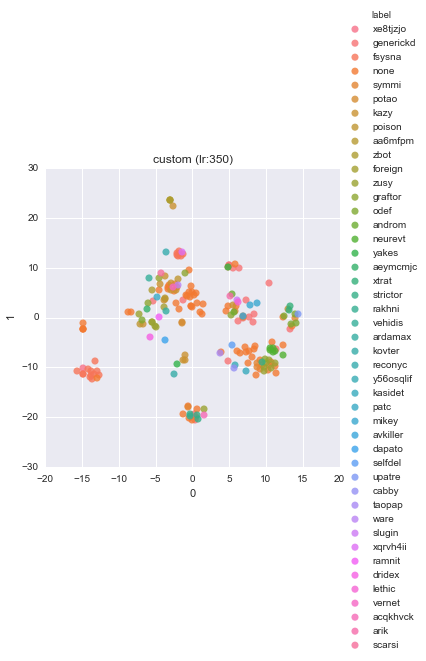

In [10]:
ml.visualise_data(data=simple_features, labels=ml.labels, learning_rate=350)

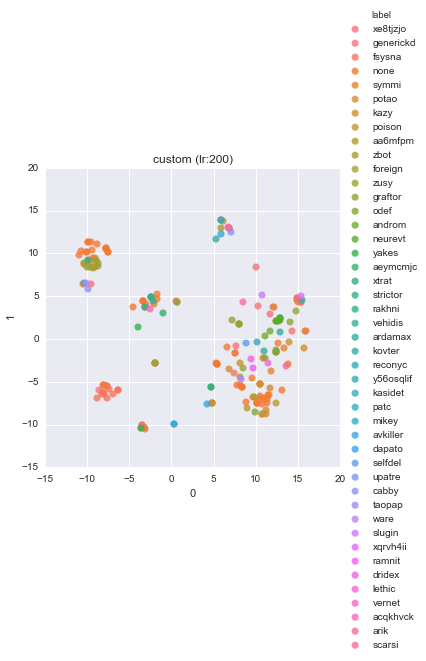

In [11]:
ml.visualise_data(data=features_nominal, labels=ml.labels)

As we gathered numerical features in separate dataset it might be worth looking into them. One approach is to seek for *abnormal behaviour* based on distinctively large number of operations of given type.

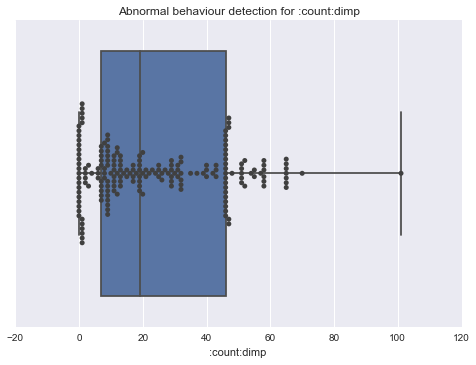

:count:dimp
Outliers:  
Suspected outliers:  
------------------------------------------------------------


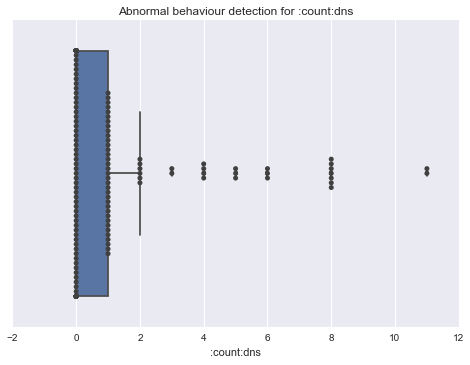

:count:dns
Outliers:  105, 131, 146, 154, 170, 189, 192, 26, 27, 29, 43, 62, 75, 93, 95
Suspected outliers:  117, 14, 151, 18, 46, 5
------------------------------------------------------------


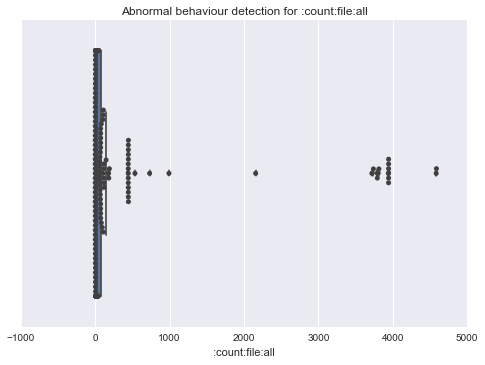

:count:file:all
Outliers:  105, 106, 109, 128, 137, 144, 146, 147, 152, 153, 157, 158, 163, 170, 173, 18, 192, 195, 20, 24, 27, 32, 48, 55, 57, 60, 70, 75, 78, 93, 94
Suspected outliers:  187, 40, 65
------------------------------------------------------------


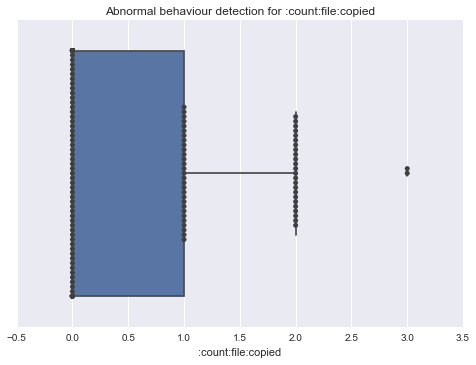

:count:file:copied
Outliers:  
Suspected outliers:  49, 69
------------------------------------------------------------


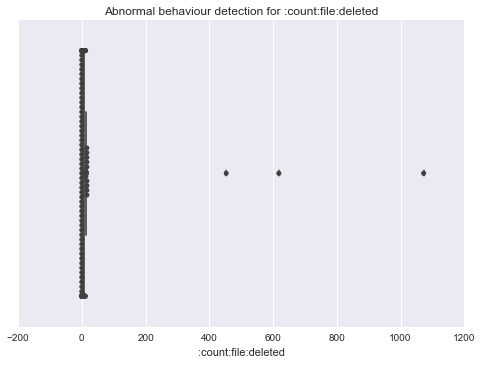

:count:file:deleted
Outliers:  152, 18, 78
Suspected outliers:  116, 125, 132, 133, 143, 166, 59, 85, 96
------------------------------------------------------------


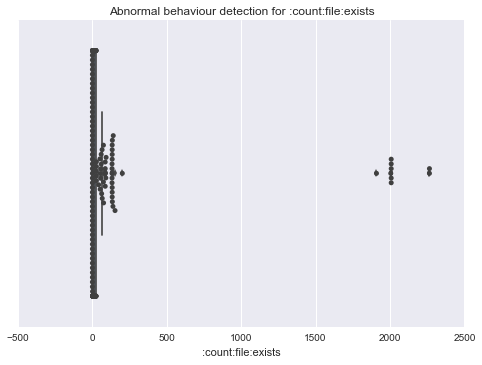

:count:file:exists
Outliers:  105, 106, 109, 128, 137, 144, 146, 147, 153, 157, 158, 163, 170, 187, 192, 195, 20, 24, 27, 32, 40, 55, 60, 65, 75, 93, 94
Suspected outliers:  121, 135, 141, 19, 49, 56, 64, 84, 9
------------------------------------------------------------


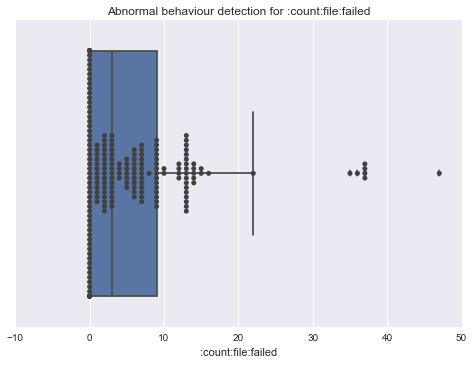

:count:file:failed
Outliers:  173, 18, 48, 57, 70
Suspected outliers:  20, 60
------------------------------------------------------------


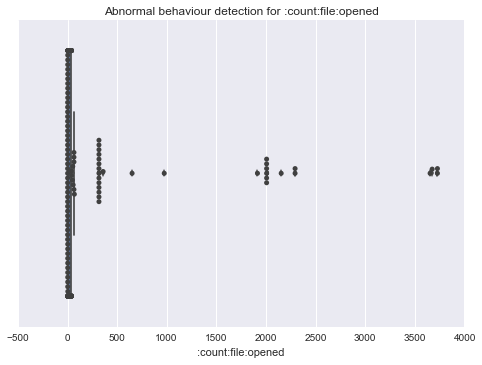

:count:file:opened
Outliers:  105, 106, 109, 128, 137, 144, 146, 147, 152, 153, 157, 158, 163, 170, 173, 18, 192, 195, 20, 24, 27, 32, 48, 55, 57, 60, 70, 75, 78, 93, 94
Suspected outliers:  
------------------------------------------------------------


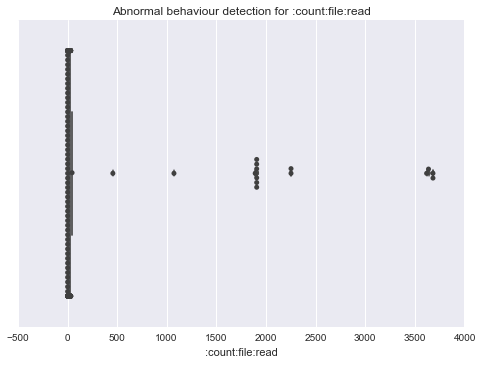

:count:file:read
Outliers:  105, 146, 152, 170, 173, 192, 20, 27, 48, 57, 60, 70, 75, 78, 93
Suspected outliers:  
------------------------------------------------------------


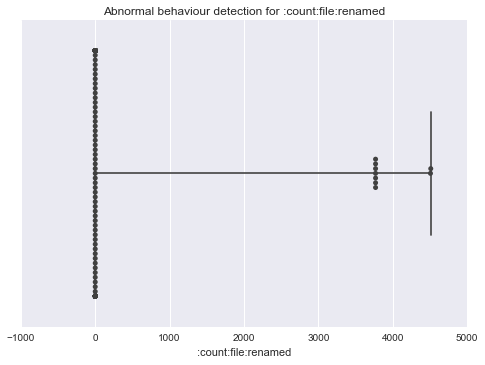

:count:file:renamed
Outliers:  105, 115, 130, 138, 139, 140, 146, 148, 162, 165, 168, 169, 170, 187, 191, 192, 194, 196, 2, 20, 27, 38, 42, 60, 65, 75, 79, 89, 90, 93
Suspected outliers:  
------------------------------------------------------------


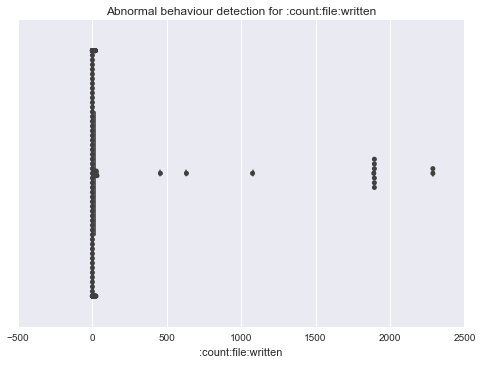

:count:file:written
Outliers:  105, 146, 152, 153, 170, 18, 192, 20, 27, 60, 75, 78, 93
Suspected outliers:  106, 109, 128, 137, 144, 147, 157, 158, 163, 187, 195, 24, 32, 40, 49, 55, 65, 9, 94
------------------------------------------------------------


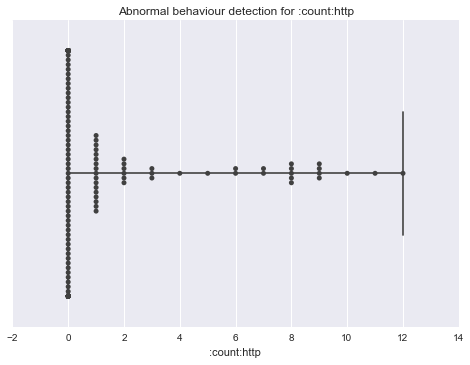

:count:http
Outliers:  10, 105, 11, 110, 117, 118, 127, 131, 135, 141, 145, 146, 151, 154, 155, 160, 161, 168, 170, 174, 175, 176, 179, 18, 185, 190, 192, 20, 26, 27, 29, 36, 43, 47, 5, 51, 54, 60, 62, 68, 75, 9, 93, 95
Suspected outliers:  
------------------------------------------------------------


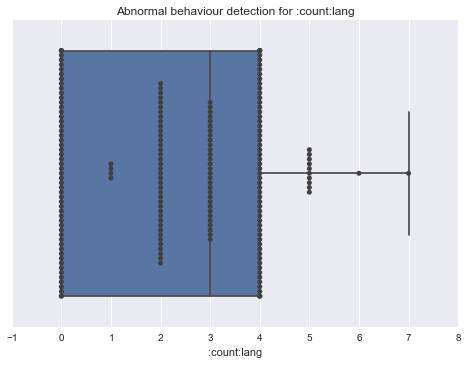

:count:lang
Outliers:  
Suspected outliers:  
------------------------------------------------------------


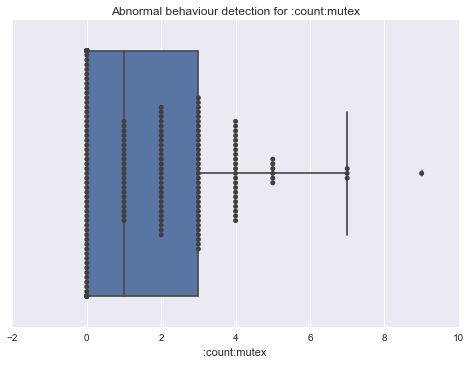

:count:mutex
Outliers:  
Suspected outliers:  18
------------------------------------------------------------


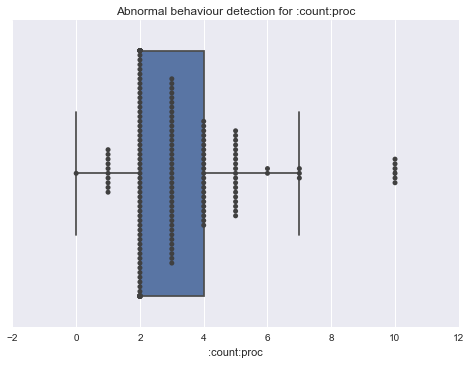

:count:proc
Outliers:  
Suspected outliers:  105, 146, 170, 27, 75, 93
------------------------------------------------------------


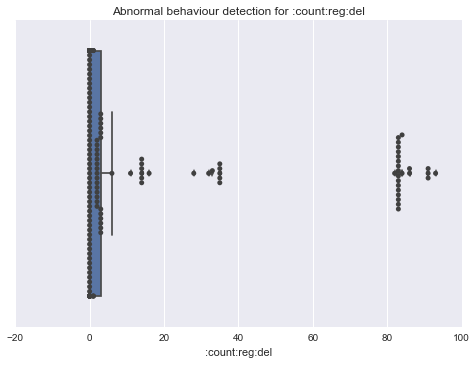

:count:reg:del
Outliers:  105, 106, 109, 121, 128, 13, 135, 137, 141, 142, 144, 146, 147, 149, 152, 153, 157, 158, 163, 170, 171, 175, 179, 187, 19, 195, 24, 27, 32, 40, 49, 55, 56, 64, 65, 75, 84, 9, 93, 94
Suspected outliers:  192
------------------------------------------------------------


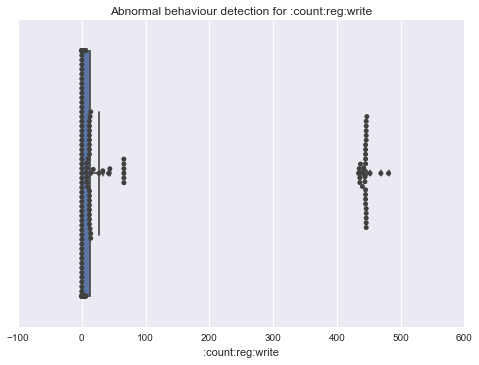

:count:reg:write
Outliers:  105, 106, 109, 121, 128, 13, 135, 137, 141, 142, 144, 146, 147, 149, 153, 157, 158, 163, 170, 171, 175, 179, 187, 19, 195, 24, 27, 32, 40, 49, 55, 56, 64, 65, 75, 84, 9, 93, 94
Suspected outliers:  152, 174, 192
------------------------------------------------------------


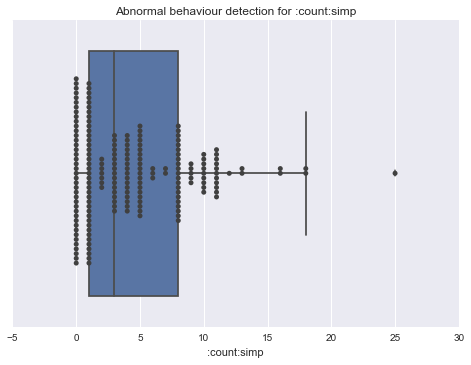

:count:simp
Outliers:  
Suspected outliers:  198
------------------------------------------------------------


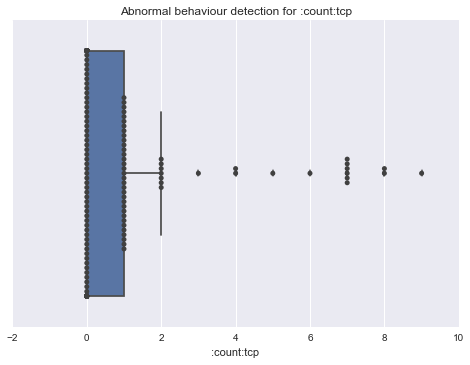

:count:tcp
Outliers:  105, 146, 170, 192, 20, 27, 43, 60, 62, 75, 93
Suspected outliers:  18, 26, 29
------------------------------------------------------------


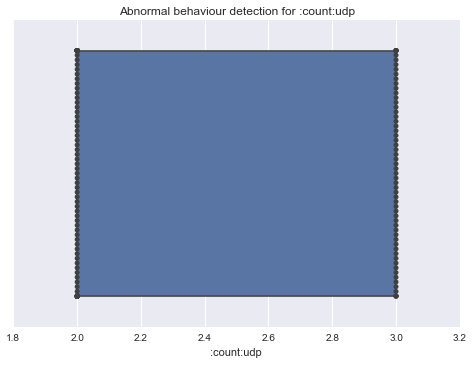

:count:udp
Outliers:  
Suspected outliers:  
------------------------------------------------------------


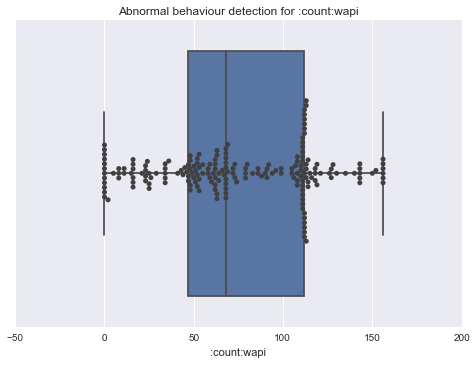

:count:wapi
Outliers:  
Suspected outliers:  
------------------------------------------------------------


In [12]:
ml.detect_abnormal_behaviour(features_numerical)

Now, that we have analysed our dataset and know *every single detail* about it we can cluster it. At the moment the clustering algorithm of our choosing is **HDBSCAN**. Let's see what it can do with the malware saples.  
We try it on both *simple* and *full nominal* feature spaeces. Additionally we an try it with sparse features filtered out.

Additionally we print the clustering quality measures to assess which one is the best.

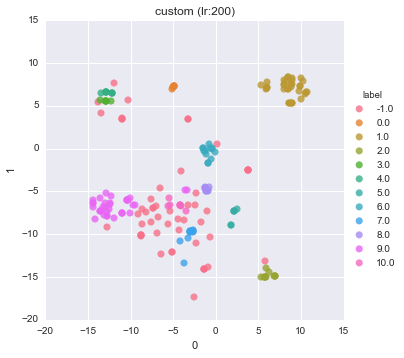

{'Adjusted Mutual Information Score': 0.2137627254628825,
 'Adjusted Random Index': 0.11345428545477139,
 'Completeness': 0.51371644070930855,
 'Homogeneity': 0.40615452416624492,
 'Silhouette Coefficient': 0.24021846060914206,
 'V-measure': 0.45364679286489618}


In [13]:
nominal_clusters = ml.cluster_hdbscan(features_nominal, dry=True)
ml.visualise_data(data=features_nominal, labels=nominal_clusters["clustering"])

pprint(ml.assess_clustering(nominal_clusters["clustering"], labels, features_nominal))

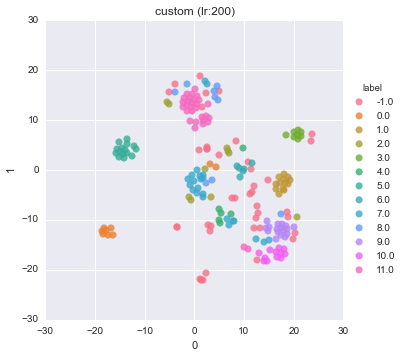

{'Adjusted Mutual Information Score': 0.19499599908424164,
 'Adjusted Random Index': 0.0758234587868585,
 'Completeness': 0.4768028269103578,
 'Homogeneity': 0.41388614886716896,
 'Silhouette Coefficient': 0.26281592769236894,
 'V-measure': 0.44312232702024318}


In [14]:
simple_clusters = ml.cluster_hdbscan(simple_features, dry=True)
ml.visualise_data(data=simple_features, labels=simple_clusters["clustering"])

pprint(ml.assess_clustering(simple_clusters["clustering"], labels, simple_features))

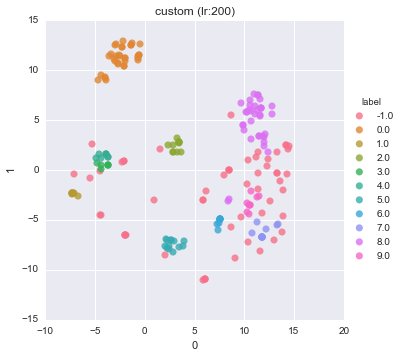

{'Adjusted Mutual Information Score': 0.18561121998710151,
 'Adjusted Random Index': 0.09932513487989637,
 'Completeness': 0.49125926993286956,
 'Homogeneity': 0.37455827097943967,
 'Silhouette Coefficient': 0.28439021194487296,
 'V-measure': 0.42504387830902968}


In [15]:
features_nominal_filtered = ml.filter_dataset(features_nominal)

nominal_clusters_filtered = ml.cluster_hdbscan(features_nominal_filtered, dry=True)
ml.visualise_data(data=features_nominal_filtered, labels=nominal_clusters_filtered["clustering"])

pprint(ml.assess_clustering(nominal_clusters_filtered["clustering"], labels, features_nominal_filtered))

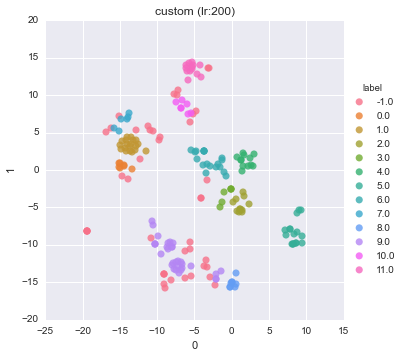

{'Adjusted Mutual Information Score': 0.24083108560105068,
 'Adjusted Random Index': 0.1368612380343698,
 'Completeness': 0.51831401985476744,
 'Homogeneity': 0.44512204930226917,
 'Silhouette Coefficient': 0.33168057325852018,
 'V-measure': 0.47893784774264192}


In [16]:
simple_features_filtered = ml.filter_dataset(simple_features)

simple_clusters_filtered = ml.cluster_hdbscan(simple_features_filtered, dry=True)
ml.visualise_data(data=simple_features_filtered, labels=simple_clusters_filtered["clustering"])

pprint(ml.assess_clustering(simple_clusters_filtered["clustering"], labels, simple_features_filtered))

Say we really like the clustering with *filtered simple dataset*. Let's see what more we can do with it.

First of all we can save the clustering results in memory.

In [17]:
ml.cluster_hdbscan(simple_features_filtered)

Then we can visualise per cluster ground truth label statistics.

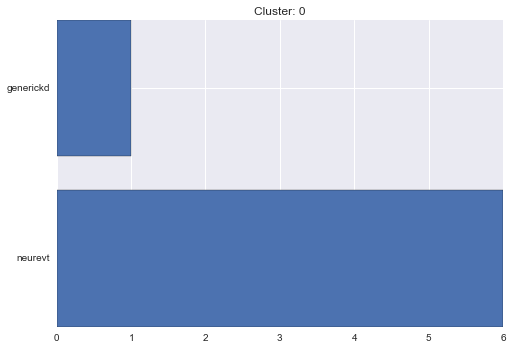

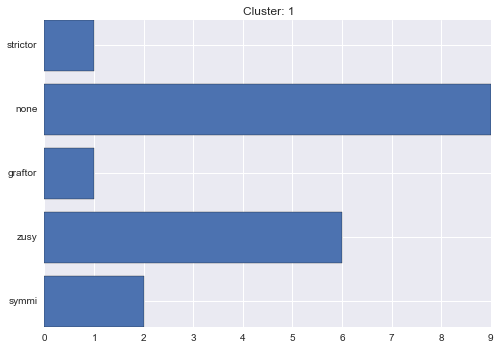

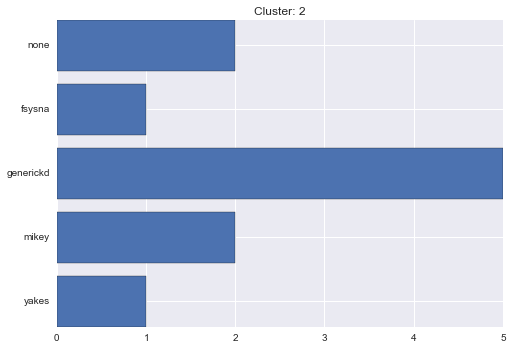

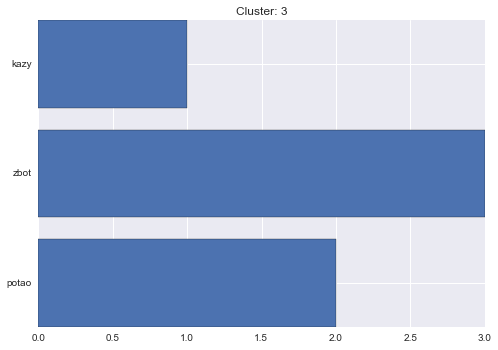

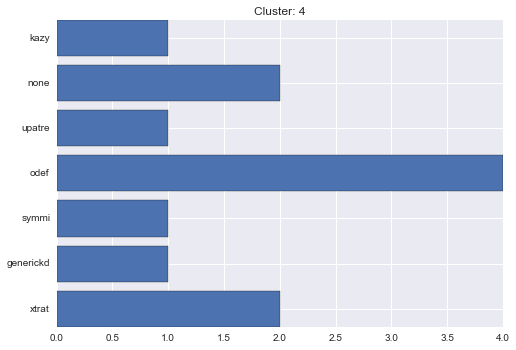

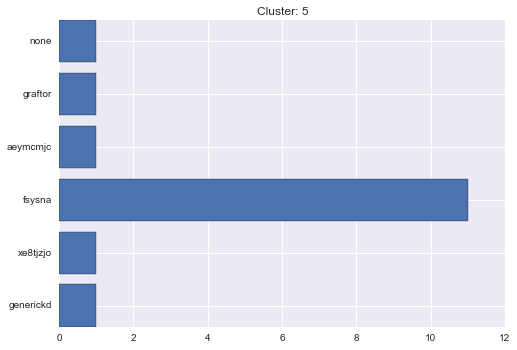

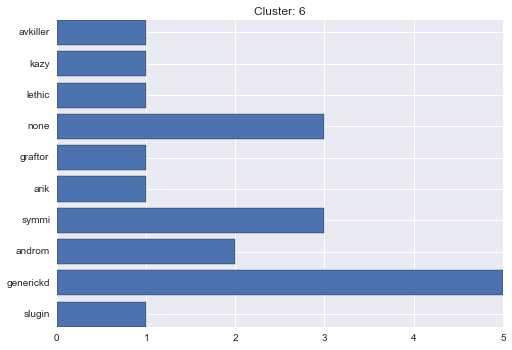

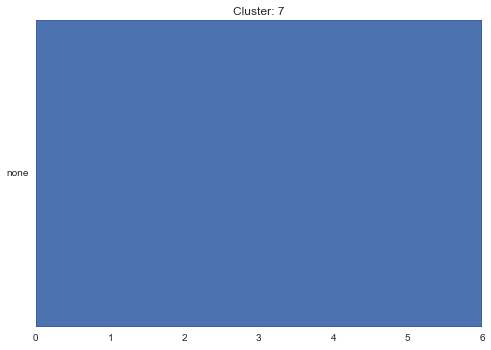

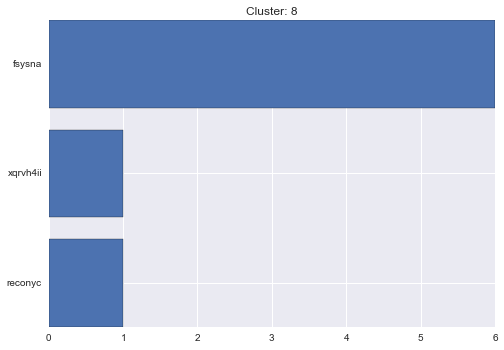

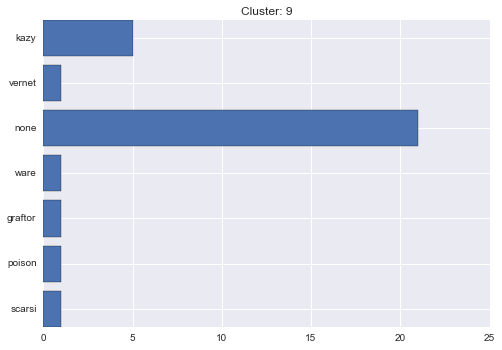

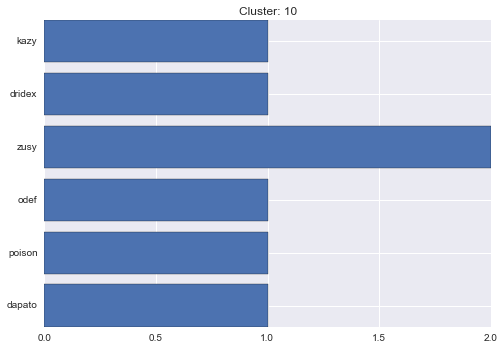

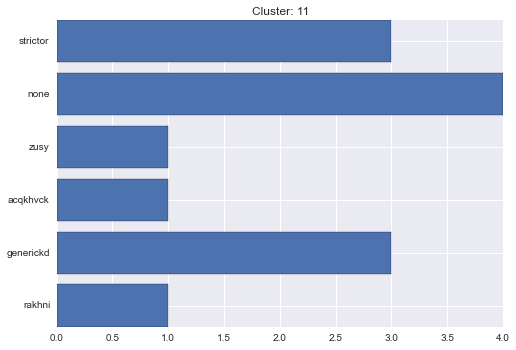

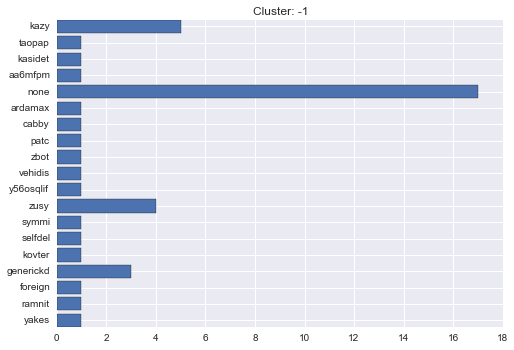

In [18]:
ml.clustering_label_distribution(ml.clustering["hdbscan"]["clustering"], ml.labels, plot=True)

Are we still happy with the clustering?  
For the sake of this example let's say *yes*.

We can now compare a new sample to in-memory clustering (we're heating here a bit as we simply use already existing sample and rename it, but shh... nobody will notice).

In [19]:
new_sample = Instance()

new_sample.load_json("../sample_data/dict/5", "5_new")
new_sample.label_sample()
new_sample.extract_features()
new_sample.extract_basic_features()

# compare the new sample
pprint(ml.compare_sample(new_sample))

label            0
probability      1
outlier_score    0
Name: ?5_new, dtype: float64


If you're curious whether there are any striking anomalies we can run couple of tests. Let's see what happens.

In [20]:
pprint(ml.anomaly_detection())

{'high_outlier_score': [],
 'homogeneity_suspects': {-1.0: ['114',
                                 '72',
                                 '46',
                                 '65',
                                 '197',
                                 '187',
                                 '189',
                                 '49',
                                 '168',
                                 '123',
                                 '122',
                                 '120',
                                 '108',
                                 '159',
                                 '16',
                                 '193',
                                 '81',
                                 '18',
                                 '172',
                                 '167',
                                 '22',
                                 '36',
                                 '68',
                                 '174',
                       

/usr/local/lib/python2.7/site-packages/pandas/core/frame.py:1997: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


Finally, we can save the slustering results (cluster ID, probability of cluster membership, and outlier score) inside the original JSONS that we read into the memory at the begining.

In [21]:
ml.save_clustering_results(loader, "../sample_data/dict_cluster")

I hope you liked `cuckooml` and you're ready to use it and contribute to it.  
Enjoy!